In [2]:
from scipy.optimize import fsolve
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import random
from numpy.linalg import eig
from control import matlab
from control import dlqr
from scipy.signal import place_poles
from scipy.io import savemat

In [3]:
# Define variables
Ca0=4
rho=1000
Cp=0.231
F=5
V=1
delH=-1.15*10**4
E=5*10**4
T0=300
k0=8.46*10**6
Rc=8.314

In [4]:
# Solve for Ca, T
def ss(p):
    Ca, T = p
    e1=(F/V)*(Ca0-Ca)-k0*np.exp(-E/(Rc*T))*Ca**2
    e2=(F/V)*(T0-T)-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*T))*Ca**2
    return (e1, e2)

CAs, Ts =  fsolve(ss, (1,400))
print(CAs,Ts)

1.2230500795162234 438.24642461282866


In [5]:
# a11=0.7364
# a12=-0.0041
# a21=10.6953
# a22=1.1560
# b1=-9.0708*10**-8
# b2=4.6741*10**-5
# g1=1.0513
# g2=1.0513


In [6]:
a11 = - (F/V) -2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)
a12 = - k0*( (CAs)**2 )*np.exp(-E/(Rc*(Ts)))*(E/(Rc*(Ts)**2))
a21 = - 2* (CAs)*((delH*k0)/(rho*Cp)) * np.exp(-E/(Rc*(Ts)))
a22 = - (F/V) - ((delH*k0*( (CAs)**2 ))/(rho*Cp)) * np.exp(-E/(Rc*(Ts)))*(E/(Rc*(Ts)**2))
b1  = 0
b2  = 1/(rho*Cp*V)
g11 = F/V
g12 = 0
g21 = 0
g22 = F/V

In [7]:
# Define the LQR system matrices
A_c=np.array([[a11,a12],[a21,a22]])
B_c=np.array([[b1],[b2]])
C_d = np.array([[1, 0], [0, 1]])
D = np.array([[0],[0]])
E_c = np.array([[g11, g12], [g21, g22]])
# w,v=eig(A)
# print(B)

In [8]:
# Compute the values of Discretized A,B,C
# sys = matlab.ss(A_c, B_c, C_c, D)
# Tos=0.01
# sys1= matlab.c2d(sys, Tos, method='zoh')

# A_d=sys1.A
# B_d=sys1.B
# C_d=sys1.C
# print(A_d)
# print(B_d)
# print(Q)


In [9]:
##### Define the decision variables and control inputs

num_states,num_control_inputs = B_c.shape                                       # Number of states 
num_outputs = len(C_d)
num_steps = 500
tot_time = num_steps
dt = 0.01  
# # x0 = np.array([[0.1]])
x0 = np.array([[0.0], [0.0]])
# cost1=0

In [10]:
# Continuous-time to discrete-time conversion (FUNCTION)
from typing import Tuple
import numpy as np
from scipy.linalg import expm
def c2d(
    a_c: np.ndarray, b_c: np.ndarray, sample_period: float
    ) -> Tuple[np.ndarray]:
    """
    Continuous to discrete conversion of A and B given a sample period
    Args:
         a_c (np.ndarray): A matrix
         b_c (np.ndarray): B matrix
         sample_period (float): Sample period
    Returns:
        :obj:`tuple` of :obj:`np.ndarray`: matrix pair (Ad, Bd)
    """
    (n_x, n_u) = b_c.shape
    phi = np.concatenate(
        [np.concatenate([a_c, b_c], axis=1), np.zeros([n_u, n_x + n_u])],
        axis=0,
        )
    phi = expm(phi * sample_period)
    return (phi[:n_x, :n_x], phi[:n_x, n_x:(n_x + n_u)])

In [11]:
# Continuous-time to discrete-time conversion (FUNCTION)
## Exact method discretization (Second approach)
sample_period = 0.01    # in second
A_d = np.zeros((num_states,num_states))
B_d = np.zeros((num_states, num_control_inputs))
E_d = np.zeros((num_states, num_states))
BcEc = np.hstack((B_c, E_c))
BdEd = np.zeros((num_states,num_control_inputs+num_states))
# for i in range(num_steps):
#     A_c [:,:,i] = np.array(A_c [:,:,i])
#     B_c [:,:,i] = np.array(B_c [:,:,i])
#     E_c [:,:,i] = np.array(E_c [:,:,i])
#     BcEc [:,:,i] = np.hstack((B_c[:,:,i], E_c[:,:,i]))
# Get the dimensions of B_c and C_c
n_x, n_u = B_c.shape
A_d, BdEd  = c2d(A_c , BcEc , sample_period)
# Extract the discrete B_c and C_c from BdCd
B_d [:,:] = BdEd[:, :n_u]
E_d [:,:] = BdEd[:, n_u:]
# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(A_d)
# Print the eigenvalues
print("Eigenvalues of matrix A_d are:")
print(eigenvalues)
print ("A_d:")
print (A_d)
print ("B_d:")
print (B_d)
print ("E_d:")
print (np.shape(E_d))

Eigenvalues of matrix A_d are:
[0.94119361 0.95122942]
A_d:
[[ 7.36392975e-01 -4.11382138e-03]
 [ 1.06953211e+01  1.15603006e+00]]
B_d:
[[-9.07079550e-08]
 [ 4.67413705e-05]]
E_d:
(2, 2)


In [12]:
Ke=np.array([180800.91455,12463.2645])

In [13]:
print(Ke@(np.linalg.inv(A_d))@B_d)

[0.51031835]


In [14]:
Q = np.array([[5e+8, 0], [0, 2e+10]])        # State cost matrix
# # Q = np.array([[4.91368059e+10, 0], [0, 1.87123559e+08]])
R = np.array([[1]])                                      # Control cost matrix

In [15]:
K, S, V = dlqr(A_d, B_d, Q, R)
# P1=np.array([-0.8,-0.85])
# P2=np.array([-0.2,-0.3])
# K=place_poles(A_d, B_d, P1, method='YT').gain_matrix
# L = np.transpose(place_poles(A.T, C.T, P2).gain_matrix)
# K = np.array([[-17968966.37029428],[45195.24611119]]).T
At = np.array([[1, 0], [0, 1.2]])
w,v=eig(A_d-B_d@K)
print(K)
print(w)

[[227859.65914403  24184.38620885]]
[0.75694391 0.02573645]


In [16]:
alpha1=0.01
alpha2=0.2

In [17]:
##### Store the states, outputs and controls for plotting (I have replaced tot_time with num_steps for the building model)

states = np.zeros((num_states, tot_time+1))
output = np.zeros((num_outputs, tot_time+1))
dist_ol = np.zeros((num_states, tot_time+1))
controls = np.zeros((num_control_inputs, tot_time+1))
rate_MPC = np.zeros((tot_time+1))
tot_cost_MPC = np.zeros((tot_time+1))
dist_MPC = np.zeros([4,tot_time+1])
norm_x = np.zeros((tot_time+1))
norm_y = np.zeros((tot_time+1))

In [18]:
##### Closed-loop MPC    
random.seed(0)
for n in range(tot_time):
    print('Time step:',n)
    mpc = Model()
    
    x_var = np.array([[mpc.continuous_var(name=f"x_var{i}_{j}",lb=-mpc.infinity) for j in range(num_steps+1)] for i in range(num_states)])
    u_var = np.array([[mpc.continuous_var(name=f"u_var{i}_{j}",lb=-mpc.infinity,ub=mpc.infinity ) for j in range(num_steps)] for i in range(num_control_inputs)])

    #### Open-loop MPC

    # ### Define disturbances and noise
    
    dist_1=random.uniform(-alpha1, alpha1)                                            # Disturbance in state 1
    dist_2=random.uniform(-alpha2, alpha2)                                            # Disturbance in state 2
    # d=[[dist_1]]
    d=np.array([[dist_1],[dist_2]])
    for i in range(num_steps):
        dist_ol[0,i]=dist_1
        dist_ol[1,i]=dist_2
    print(np.shape(d))
    noise_1=random.uniform(-alpha1, alpha1)
    noise_2=random.uniform(-alpha2, alpha2)
    noise=[[noise_1],[noise_2]]
    # noise=[[noise_1]]
    dist_MPC[:,n] = [dist_1,dist_2,noise_1,noise_2]

    ### Add the state space equations as contraints
    for i in range(num_steps):
        for m in range (num_states):
            ## Create the state space equations
            state_eq = mpc.sum(A_d[m, j] * x_var[j, i] for j in range(num_states))
            control_eq = mpc.sum(B_d[m, k] * u_var[k, i] for k in range(num_control_inputs))
            # dist_eq = mpc.sum(E_d[m,l] * dist_ol[l,i] for l in range(num_states))

            ## Add the constraint for the current time step
            mpc.add_constraint(x_var[m, i + 1] == state_eq + control_eq)

    ### Initial condition
    y0 = At @ (C_d @ x0 + noise)
    mpc.add_constraint(x_var[0,0] == y0[0,0])
    mpc.add_constraint(x_var[1,0] == y0[1,0])

    ### Create the objective expression 
    J = []
    for i in range(num_steps):
        state_cost = 0
        input_cost = 0
        for m in range(num_states):
            state_cost += mpc.sum(x_var[m,i] * Q[m,j] * x_var[j,i] for j in range(num_states))
        for m in range(num_control_inputs):
            input_cost += mpc.sum(u_var[m,i] * R[m,j] * u_var[j,i] for j in range(num_control_inputs))
        J.append(state_cost + input_cost) 
      

    ### Set the objective sense and expression in the model
    objective = mpc.sum(J[j]   for j in range(num_steps))
    # print(objective)
    mpc.set_objective("minimize", objective)

    ### Solve the model
    solution_tot = mpc.solve()
    # mpc.print_information()
    # print(mpc.solve_details)
    # print(solution_tot)

    # Check if the solution was successful (non-empty)
    if not solution_tot:
        n=n-2
    # if the optimization is infeasible, the loop will break. After the break the x0 value assigned in states will have no use as that is already done. Also, in plotting only n-1 states willbe printed
        print("Solution not found. Exiting loop.")
        break
       
    ### Extract the values for X and U from the solution
    X_values = np.array([[solution_tot[x_var[k, j]] for j in range(num_steps+1)] for k in range(num_states)])
    U_values = np.array([[solution_tot[u_var[k, j]] for j in range(num_steps)] for k in range(num_control_inputs)])
    


    # print(U_values)
    ### Calculating the optimized objective cost
    opt_cost = [solution_tot[objective]]
    print('Cost:',opt_cost)
    cost=0
    
    x = np.zeros((2,num_steps+1))
    for i in range(num_states):
        x[i,0] = y0[i,0]
    for j in range(num_steps):
        x[:,j+1] = A_d @ X_values[:,j] + B_d @ U_values[:,j]
        cost += X_values[:,j].T @ Q @ X_values[:,j] + U_values[:,j].T @ R @ U_values[:,j]
        # state_cost += X_values[:,j].T @ Q @ X_values[:,j]
        # input_cost += U_values[:,j].T @ R @ U_values[:,j]

    
    

    ### Store values of closed-loop state and trajectories

    u_mpc = np.array([[U_values[k,0]] for k in range(num_control_inputs)])
    for j in range(num_states):
        states[j, n] = x0[j,:]                                                             # Store closed-loop states for Q
        output[j, n] = y0[j,:]
        
    for j in range(num_control_inputs):
        controls[j, n] = u_mpc[j,:]                                                        # Store closed-loop inputs for Q
    print(x0)
    print(((x0[0,0])**2+x0[1,0]**2)**0.5)
    norm_x[n] = ((x0[0,0])**2+x0[1,0]**2)**0.5
    norm_y[n] = ((y0[0,0])**2+y0[1,0]**2)**0.5
    rate_MPC[n] = k0*np.exp(-E/(Rc*(Ts)))*(CAs)**2+2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)*(states[0,n])+(k0*E/(Rc*(Ts**2)))*(np.exp(-E/(Rc*(Ts)))*(CAs)**2)*(states[1,n])
    tot_cost_MPC[n] = states[:,n].T @ Q @ states[:,n] + controls[:,n].T @ R @ controls[:,n]
    # tot_cost_MPC[n] =  controls[:,n].T @ R @ controls[:,n]
    # cost1 += x0.T @ Q @ x0 + u_mpc.T @ R @ u_mpc
    x0 = A_d @ x0 + B_d @ u_mpc + E_d @ d                                                     # Optimal initial state for the next iteration of open-loop simulation

print(n)
if n==num_steps-1:
    for j in range(num_states):
        states[j, n+1] = x0[j,:]
        output[j, n+1] = y0[j,:]
    norm_x[n] = ((x0[0,0])**2+x0[1,0]**2)**0.5
    norm_y[n] = ((y0[0,0])**2+y0[1,0]**2)**0.5
    controls[0,n+1] = controls[0,n]
    tot_cost_MPC[n+1] = tot_cost_MPC[n]
    rate_MPC[n+1] = rate_MPC[n]
    dist_MPC[:,n+1] = dist_MPC[:,n]
    

Time step: 0


(2, 1)
Cost: [278154074.07650644]
[[0.]
 [0.]]
0.0
Time step: 1
(2, 1)
Cost: [183274913.4564075]
[[7.63903307e-07]
 [1.55176836e-01]]
0.15517683554819545
Time step: 2
(2, 1)
Cost: [15904584.627106458]
[[-0.00030534]
 [ 0.01317148]]
0.013175020292655278
Time step: 3
(2, 1)
Cost: [1068626950.6940715]
[[-0.0001008 ]
 [-0.09045597]]
0.0904560276925086
Time step: 4
(2, 1)
Cost: [2581692092.257023]
[[-0.00035574]
 [ 0.13262502]]
0.13262549693940326
Time step: 5
(2, 1)
Cost: [1480887120.304207]
[[ 0.00042053]
 [-0.29823821]]
0.29823850587152856
Time step: 6
(2, 1)
Cost: [174873590.50843367]
[[ 0.00094473]
 [-0.12105192]]
0.121055605317934
Time step: 7
(2, 1)
Cost: [396600605.93040913]
[[ 0.0009767 ]
 [-0.03061052]]
0.030626094807956517
Time step: 8
(2, 1)
Cost: [4031845699.514831]
[[ 0.00149804]
 [-0.17481294]]
0.1748193631287482
Time step: 9
(2, 1)
Cost: [3905013004.172304]
[[0.0006813 ]
 [0.29369932]]
0.2937001079063544
Time step: 10
(2, 1)
Cost: [3063118825.33149]
[[ 0.00058656]
 [-0.22026

In [19]:
savemat('python_variable_attack.mat', {'output': output})
ans=np.zeros((num_states,tot_time+1))

In [20]:
print(A_d-B_d@K@At@C_d)
print([[E_d,-B_d@K@At@C_d]])
print(max(norm_x))
print(max(norm_y))

[[ 0.75706166 -0.00148136]
 [ 0.04484831 -0.20046357]]
[[array([[ 4.32992835e-02, -1.04767688e-04],
       [ 2.72380338e-01,  5.39862829e-02]]), matrix([[ 2.06686837e-02,  2.63245946e-03],
        [-1.06504727e+01, -1.35649363e+00]])]]
0.38178771713377113
0.6444588688443881


In [21]:
anomaly_detected = False  # Initialize a flag variable
for i in range(tot_time):
    if norm_y[i] > 0.5555: #2.7797
        print("Anamoly detected at time step",i)
        anomaly_detected = True  # Set the flag to True
        # break
    
if not anomaly_detected:
    print("No anomaly observed")


Anamoly detected at time step 101
Anamoly detected at time step 132
Anamoly detected at time step 191
Anamoly detected at time step 284
Anamoly detected at time step 434


In [22]:
x0 = np.array([[0.0], [0.0]])
cost=0

In [23]:
random.seed(0)

# Disturbance array initialization
dist_linear=np.zeros([4,num_steps+1])

# Initialization of ans(X[0],X[1])
states_linear = np.zeros([num_states,num_steps+1])
output_linear = np.zeros([num_states,num_steps+1])
controls_linear = np.zeros([num_control_inputs,num_steps+1])
rate_linear = np.zeros((tot_time+1))
tot_cost_linear = np.zeros((tot_time+1))
for i in range(num_states):
    states_linear[i,0] = x0[i]


for m in range(tot_time):       
    # X = np.array([[states_linear[0,m]]])
    X = np.array([[states_linear[0,m]],[states_linear[1,m]]])         
    delC = random.uniform(-alpha1, alpha1)
    delT = random.uniform(-alpha2, alpha2)
    noiseC = random.uniform(-alpha1, alpha1)
    noiseT = random.uniform(-alpha2, alpha2)
    noise = [[noiseC],[noiseT]]
    dist = [[delC],[delT]]
    # noise = [[noiseC]]
    # dist = [[delC]]
    dist_linear[:,m] = [delC,delT,noiseC,noiseT]
    Y = At@(C_d@X+noise)
    U = - (K@Y)
    print(m)
    # if U[:] > 1e5:
    #     U[:] = 1e5
    #     print('Optimization failed at time step:',m)
    #     # m = m-2
    # if  U[:] < -1e5:
    #     U[:] = -1e5
    #     print('Optimization failed at time step:',m)
        # m = m-2
    #     # break
    X_new = np.zeros([2,1]) 
    X_new = A_d@X+B_d@U+E_d@dist
    for i in range(num_states):
        states_linear[i,m+1] = X_new[i]
        output_linear[i,m] = Y[i]
    controls_linear[:,m] = U
    rate_linear[m] = k0*np.exp(-E/(Rc*(Ts)))*(CAs)**2+2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)*(states_linear[0,m])+(k0*E/(Rc*(Ts**2)))*(np.exp(-E/(Rc*(Ts)))*(CAs)**2)*(states_linear[1,m])
    tot_cost_linear[m] = states_linear[:,m].T @ Q @ states_linear[:,m] + controls_linear[:,m].T @ R @ controls_linear[:,m]
    print(tot_cost_linear[m])
    # tot_cost_linear[m] =  controls_linear[:,m].T @ R @ controls_linear[:,m]


if m==num_steps-1:
    controls_linear[:,m+1]=controls_linear[:,m]
    rate_linear[m+1] = rate_linear[m]
    tot_cost_linear[m+1] = tot_cost_linear[m]
    dist_linear[:,m+1] = dist_linear[:,m]
    Y = At@(C_d@X+noise)
    for i in range(num_states):
        output_linear[i,m+1] = Y[i]    


0
9989309.246990522
1
493942964.2340472
2
8429044.015832007
3
188695005.65875515
4
448813489.2277407
5
1800136524.0424318
6
298410540.7052128
7
30782323.31903323
8
714240678.7149395
9
1871866074.304907
10
1027458866.3193945
11
213674227.17840952
12
6399266.682679633
13
35717312.78563106
14
1148270804.5745254
15
17906775.507114783
16
460582226.1451296
17
108391075.82805622
18
951392349.6025172
19
831728777.081156
20
1948387931.6643553
21
385070965.3811837
22
1641836608.263047
23
148980398.08126688
24
2028160872.399393
25
40110013.66573695
26
103896016.43773894
27
27176698.012956604
28
43124379.839621894
29
191055546.09550324
30
124971044.04387878
31
1023092557.7036792
32
309703709.7773466
33
2377592168.664309
34
1550434981.185829
35
523518060.1851228
36
972361523.4804528
37
749028013.3481977
38
1365098734.305809
39
87614488.67172836
40
654030579.4029914
41
73984063.17718713
42
100752217.99430083
43
22648366.83937908
44
804894000.4116197
45
660846769.1742824
46
75086579.87908253
47
14532

In [24]:
print(abs(max(states_linear[1,:])))
sum(dist_MPC[1,:])/len(dist_MPC[1,:])
print((np.linalg.det(B_d@B_d.T)))

0.38178748567548104
3.424894579322499e-39


In [25]:
print(Ts)

438.24642461282866


In [26]:
for m in range(tot_time+1):
    for i in range(num_states):
        states_linear[1,m] = states_linear[1,m] 
        output_linear[1,m] = output_linear[1,m]

In [27]:
for m in range(tot_time+1):
    for i in range(num_states):
        states[1,m] = states[1,m] 
        output[1,m] = output[1,m]

(1, 501)


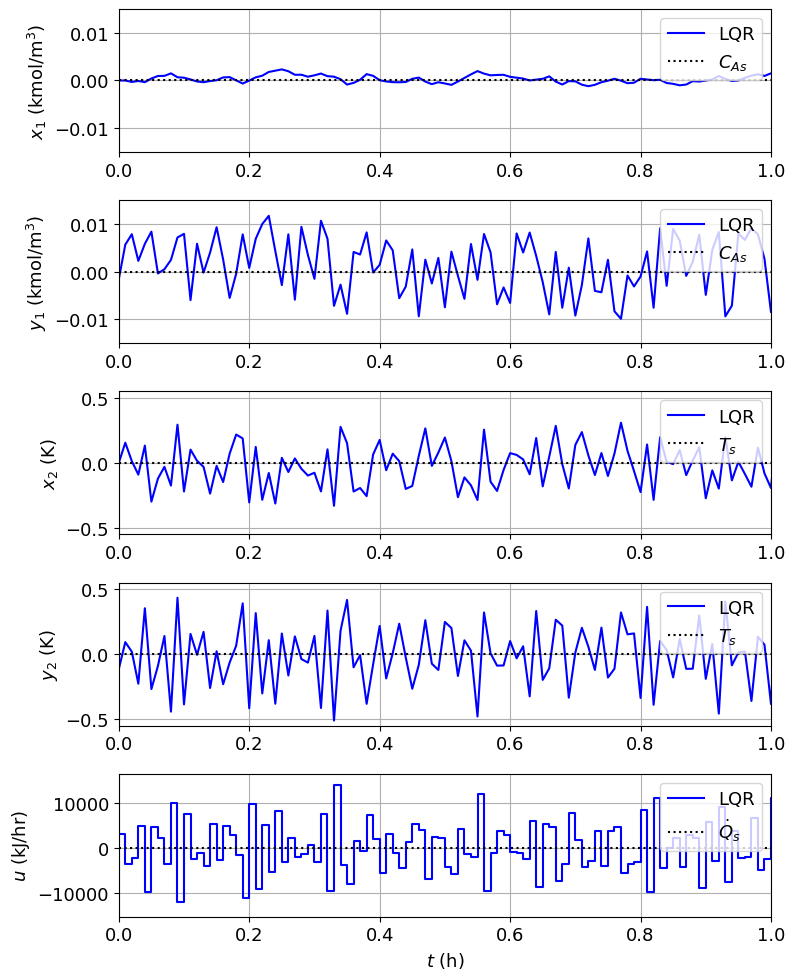

In [28]:
# Plot the results

time_steps = np.arange(num_steps+1) * dt
print(np.shape(controls))
plt.rcParams.update({'font.size': 13})
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(8)

ax = fig.add_subplot(5, 1, 1)
ax.plot(time_steps[:m+2], states_linear[0,:m+2], label='LQR', color = 'blue') # states_linear[0,:m+2]+CAs
# ax.plot(time_steps[:n+2], states[0,:n+2], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$C_{As}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('State')
ax.set_ylim([-0.015,0.015])
# ax.set_ylabel('Actual concentration \n' r'$\mathrm{(kmol/m^3)}$')
ax.set_ylabel(r'$x_1 \ \mathrm{(kmol/m^3)}$')
# ax.set_title('State v/s time')
# ax.set_title('State 1 v/s time')
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 3)
ax.plot(time_steps[:m+2], states_linear[1, :m+2], label='LQR', color = 'blue') # states_linear[1, :m+2]+Ts
# ax.plot(time_steps[:n+2], states[1, :n+2], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$T_{s}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'$x_2$'' (K)')
# ax.set_ylim([437.6,438.8])
ax.set_ylim([-0.55,0.55])
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 2)
ax.plot(time_steps[:m+2], output_linear[0,:m+2], label='LQR', color = 'blue')
# ax.plot(time_steps[:n+2], output[0,:n+2], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$C_{As}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Output')
# ax.set_title('Output  v/s time')
ax.set_ylim([-0.015,0.015])
ax.set_ylabel(r'$y_1 \ \mathrm{(kmol/m^3)}$')
# ax.set_title('Output 1 v/s time')
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 4)
ax.plot(time_steps[:m+2], output_linear[1, :m+2], label='LQR', color = 'blue')
# ax.plot(time_steps[:n+2], output[1, :n+2], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$T_{s}$',linestyle='dotted')
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Measured temperature (K)')
ax.set_ylabel(r'$y_2$'' (K)')
# ax.set_ylim([437.6,438.8])
ax.set_ylim([-0.55,0.55])
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 5)
ax.step(time_steps[:m+2], controls_linear[0, :m+2], where = 'post', label = 'LQR', color = 'blue')
# ax.step(time_steps[:n+2], controls[0, :n+2], where = 'post', label = 'MPC',color='orange')
plt.axhline(0, color='black', label=r'$\dot{Q}_{s}$',linestyle='dotted')
ax.set_xlabel(r'$t$'' (h)')
# ax.set_ylabel('Control Input')
ax.set_ylabel(r'$u$'' (kJ/hr)')
# ax.set_title('Input v/s time')
ax.legend(loc="upper right")

# ax = fig.add_subplot(4, 2, 6)
# ax.plot(time_steps[:m+2], tot_cost_linear[:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], tot_cost_MPC[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Cost')
# ax.set_title('Cost v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 7)
# # ax.plot(time_steps[:m+2], norm[:m+2], label = 'Explicit controller', color = 'blue')
# # ax.plot(time_steps[:n+2], norm[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel(r'$\mathrm{Rate(kmol/m^3hr)}$')
# ax.set_title('Rate v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 8)
# ax.plot(time_steps[:m+2], dist_linear[0,:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], dist_MPC[0,:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# # ax.set_ylabel('Disturbance')
# # ax.set_title('Disturbance v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 6)
# ax.plot(time_steps[:n+2], dist_linear[2,:n+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], dist_MPC[2,:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# # ax.set_ylabel('Noise')
# # ax.set_title('Noise v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
# ax.legend()

fig.tight_layout()
for axis in fig.get_axes():
    axis.grid(True)

for axis in fig.axes:
    axis.set_xlim([0,(m+1)*dt])
# for axis in fig.axes:
#     axis.set_ylim([-1e5,1e5])
for axis in fig.axes:
#     axis.set_xlim([0,(m+1)*dt])
    axis.set_xlim([0,1])
plt.show()

(1, 501)


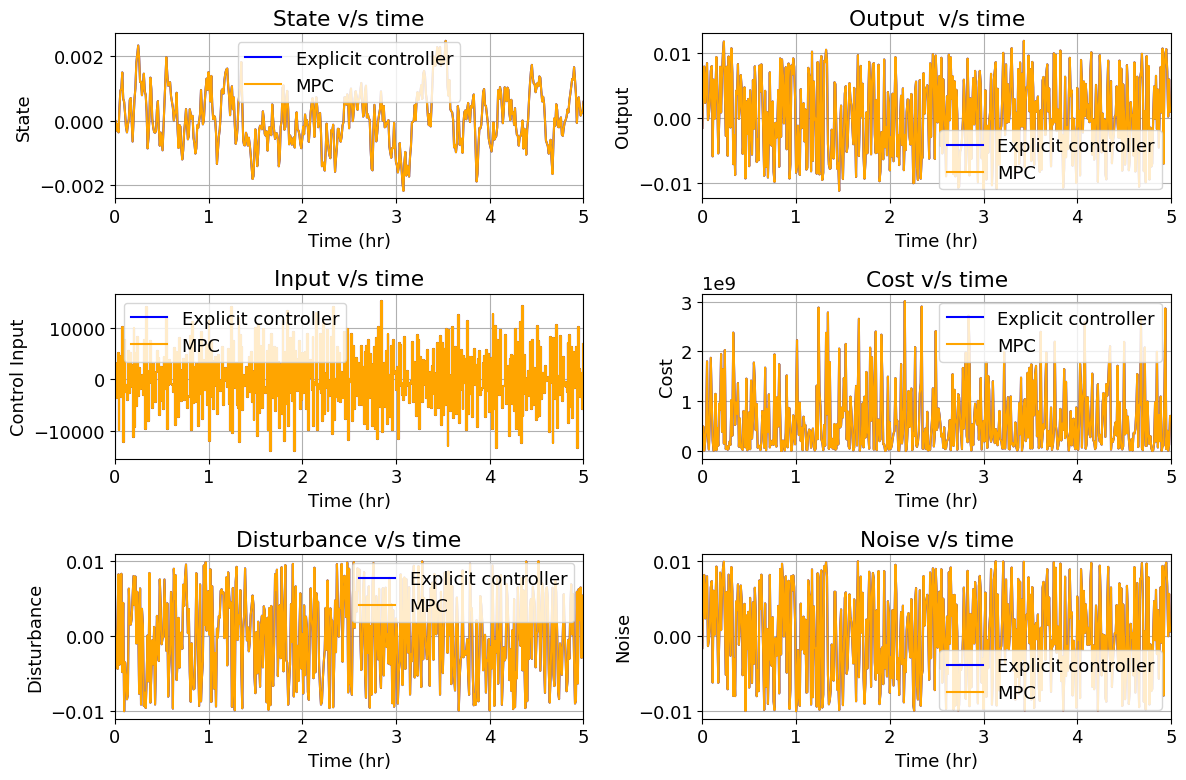

In [29]:
# Plot the results

time_steps = np.arange(num_steps+1) * dt
print(np.shape(controls))
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(12)

ax = fig.add_subplot(3, 2, 1)
ax.plot(time_steps[:n+2], states_linear[0,:n+2], label='Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], states[0,:n+2], label='MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('State')
# ax.set_ylabel(r'$\mathrm{Concentration (kmol/m^3)}$')
ax.set_title('State v/s time')
# ax.set_title('State 1 v/s time')
ax.legend()

# ax = fig.add_subplot(4, 2, 3)
# ax.plot(time_steps[:m+2], states_linear[1,:m+2]-states[1, :n+2], label='Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], states[1, :n+2], label='MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Temperature (K)')
# ax.set_title('State 2 v/s time')
# ax.legend()

ax = fig.add_subplot(3, 2, 2)
ax.plot(time_steps[:n+2], output_linear[0,:n+2], label='Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], output[0,:n+2], label='MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Output')
ax.set_title('Output  v/s time')
# ax.set_ylabel(r'$\mathrm{Concentration (kmol/m^3)}$')
# ax.set_title('Output 1 v/s time')
ax.legend()

# ax = fig.add_subplot(4, 2, 4)
# ax.plot(time_steps[:m+2], output_linear[1, :m+2], label='Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], output[1, :n+2], label='MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Temperature (K)')
# ax.set_title('Output 2 v/s time')
# ax.legend()

ax = fig.add_subplot(3, 2, 3)
ax.step(time_steps[:n+2], controls_linear[0, :n+2], where = 'post', label = 'Explicit controller', color = 'blue')
ax.step(time_steps[:n+2], controls[0, :n+2], where = 'post', label = 'MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Control Input')
# ax.set_ylabel('Control Input(kJ/hr)')
ax.set_title('Input v/s time')
ax.legend()

ax = fig.add_subplot(3, 2, 4)
ax.plot(time_steps[:n+2], tot_cost_linear[:n+2], label = 'Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], tot_cost_MPC[:n+2], label = 'MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Cost')
ax.set_title('Cost v/s time')
ax.legend()

# ax = fig.add_subplot(4, 2, 7)
# ax.plot(time_steps[:m+2], rate_linear[:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], rate_MPC[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel(r'$\mathrm{Rate(kmol/m^3hr)}$')
# ax.set_title('Rate v/s time')
# ax.legend()

ax = fig.add_subplot(3, 2, 5)
ax.plot(time_steps[:n+2], dist_linear[0,:n+2], label = 'Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], dist_MPC[0,:n+2], label = 'MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Disturbance')
ax.set_title('Disturbance v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
ax.legend()

ax = fig.add_subplot(3, 2, 6)
ax.plot(time_steps[:n+2], dist_linear[2,:n+2], label = 'Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], dist_MPC[2,:n+2], label = 'MPC',color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Noise')
ax.set_title('Noise v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
ax.legend()

fig.tight_layout()
for axis in fig.get_axes():
    axis.grid(True)

for axis in fig.axes:
    axis.set_xlim([0,(n+1)*dt])
# for axis in fig.axes:
#     axis.set_ylim([-1e5,1e5])
plt.show()